In [63]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy.signal import detrend

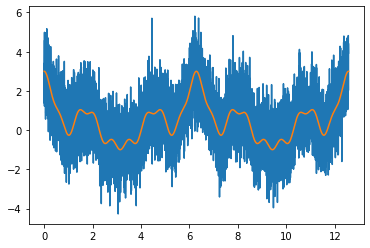

In [64]:
N = 10001
time = np.linspace(0,4*np.pi,N)

signal = np.zeros(N)

for i in range(1,4):
  signal  += np.cos(i*time)**i

noisysignal = signal + np.random.randn(N)

plt.plot(time,noisysignal,time,signal)


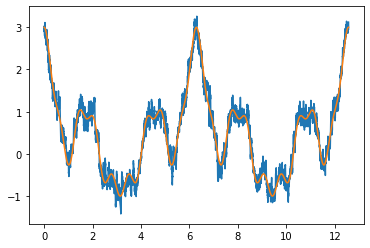

In [65]:
# Running-mean filter

filtsignal = copy.deepcopy(noisysignal)

k = 15

for t in range(N):
  lowbnd = np.max((0,t-k))
  upbound = np.min((N,t+k))
  filtsignal[t] = np.mean(noisysignal[lowbnd:upbound])
plt.plot(time,filtsignal, time,signal)

In [66]:
def meansmooth(signalIn,k):
  filtsignal = copy.deepcopy(noisysignal)

  for t in range(N):
    lowbnd = np.max((0,t-k))
    upbound = np.min((N,t+k))
    filtsignal[t] = np.mean(noisysignal[lowbnd:upbound])
  return filtsignal

In [67]:
kvals = np.arange(5,41)
sigCorrs = []
for ki in kvals:
  #filter signal
  fsig = meansmooth(noisysignal,ki)

  # compue correlation
  sigCorrs.append(np.corrcoef(fsig,signal)[0,1])

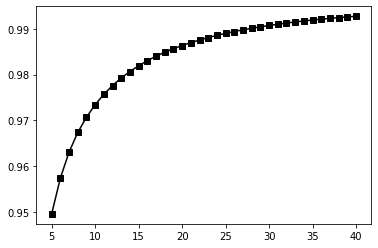

In [68]:
plt.plot(kvals,sigCorrs,'ks-')

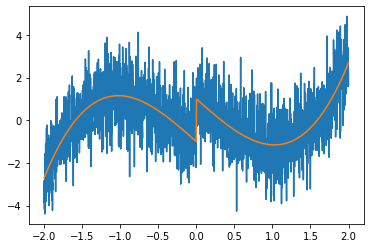

In [69]:
# Smoothing via Gaussian convolution

srate = 512
time = np.arange(-2,2+1/srate,1/srate)
pnts = len(time)

signal = detrend(time**3 + np.sign(time))
noisysignal = signal + np.random.randn(pnts)*1.1
plt.plot(time,noisysignal,time,signal)

Text(0.5, 1.0, 'n = 21, s=0.005')

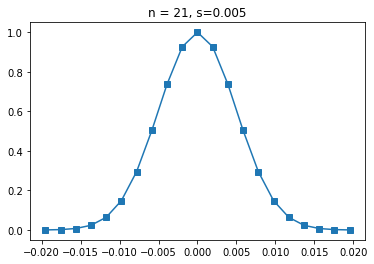

In [70]:
# create the gaussian

k = 10
x = np.arange(-k,k+1)/srate
s = .005
gkern = np.exp(-x**2/(2*s**2))
plt.plot(x,gkern,'s-')
plt.title('n = %s, s=%g'%(2*k+1,s))

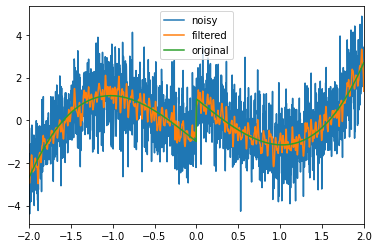

In [71]:
gkern = gkern/sum(gkern)
filtsig = np.convolve(noisysignal,gkern,mode = 'same')
plt.plot(time, noisysignal,time,filtsig,time,signal)
plt.xlim(time[[0,-1]])
plt.legend(['noisy','filtered','original'])

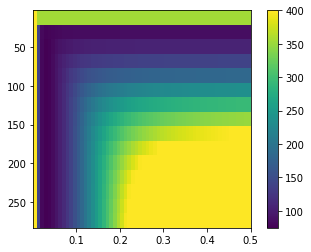

In [72]:
# define our parameter ranges
krange = np.arange(3,303,20)
srange = np.linspace(.001,.5,60)

# intialize output variables
sseMat = np.zeros((len(krange),len(srange)))
allkernels = [[0]*len(srange) for i in range(len(krange))]
# double loop over two parameters
for ki in range(len(krange)):
  for si in range(len(srange)):
    # create gaussian
    x = np.arange(-krange[ki],krange[ki]+1)/srate
    gkern = np.exp(-x**2/(2*srange[si]**2))
    # filter the signal vai convolution
    
    filtsig = np.convolve(noisysignal,gkern/sum(gkern),mode = 'same')

    # compute SSE
    sseMat[ki,si]=np.sum((filtsig-signal)**2)
    allkernels[ki][si] = gkern

plt.imshow(sseMat,vmax = 400,
           extent = [srange[0],srange[-1],krange[-1],krange[0]])
plt.gca().set_aspect(1/plt.gca().get_data_ratio())
plt.colorbar()

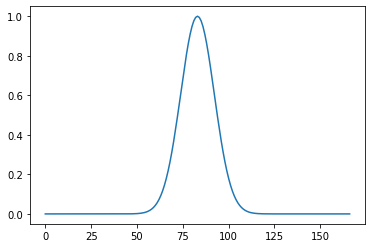

In [73]:
plt.plot(allkernels[4][2])

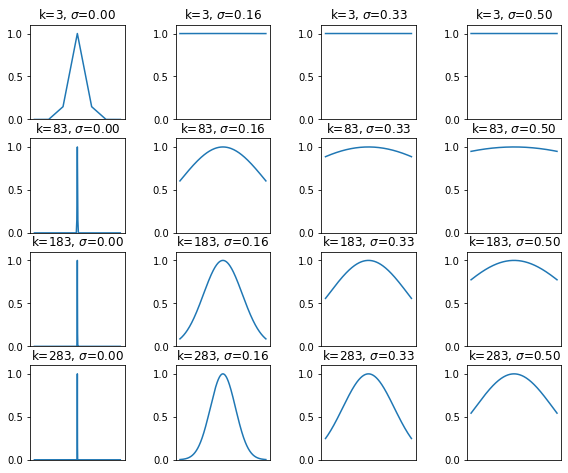

In [74]:
# plot a few non-randomly selected Gaussian kernels

fig,ax = plt.subplots(4,4,figsize=(10,8))

# 4 equally spaced points on the grid
sidx = np.linspace(0,len(srange)-1,4).astype(int)
kidx = np.linspace(0,len(krange)-1,4).astype(int)

for si in range(4):
  for kj in range(4):
    ax[kj,si].plot(allkernels[kidx[kj]][sidx[si]])
    ax[kj,si].set_xticks([])
    ax[kj,si].set_ylim([0,1.1])
    ax[kj,si].set_title('k=%g, $\sigma$=%.2f'%(krange[kidx[kj]],srange[sidx[si]]))
    ax[kj,si].set_aspect(1/ax[kj,si].get_data_ratio())

plt.show()


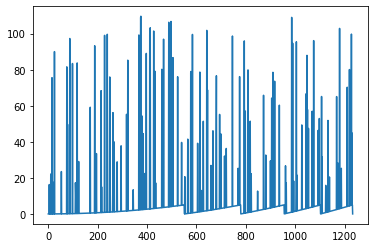

In [75]:
# Despeckling via median filter

pnts = 1234
signal = np.mod(np.linspace(0,5,pnts)**2,5)

p = int(.1*pnts)
spiketimes = np.random.randint(0,pnts,p)

signal[spiketimes] = np.random.rand(p)*100+10

plt.plot(signal)

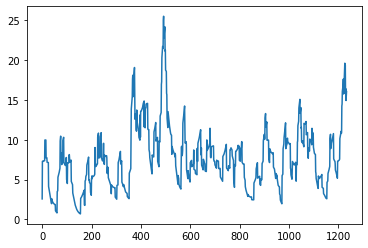

In [76]:
# try mean-filtering

k = 15

for i in range(pnts):
  signal[i] = np.mean(signal[np.max((0,i-k)):np.min((pnts,i+k))])
plt.plot(signal);

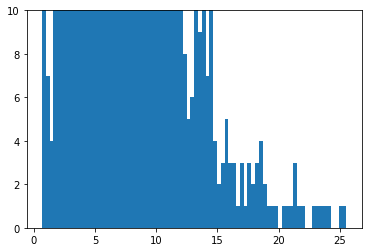

In [77]:
# empirically define spike threshold

plt.hist(signal,80)
plt.ylim([0,10])
plt.show()

In [78]:
thresh = 8

# find all super-threshold data indices

suprathresholdidx = np.where(signal>thresh)[0]

(200.0, 400.0)

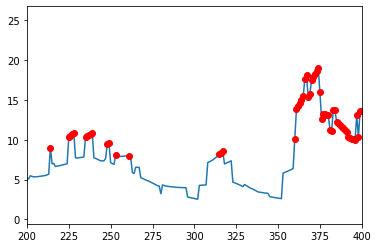

In [79]:
plt.plot(signal)
plt.plot(suprathresholdidx,signal[suprathresholdidx],'ro')
plt.xlim([200,400])

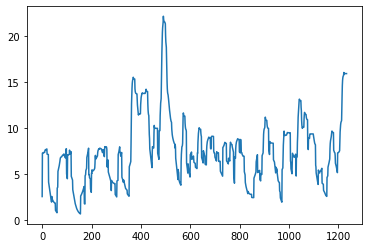

In [80]:
k = 7
for i in suprathresholdidx:
  lowbnd = np.max((0,i-k))
  uppbnd = np.min((pnts,i+k))
  signal[i] = np.median(signal[lowbnd:uppbnd])

plt.plot(signal);

In [81]:
from google.colab import files
uploaded = files.upload()

In [82]:
# Import data

import pandas as pd
df = pd.read_excel('EKG_signals.csv.xlsx', header=None, names=['noisy', 'orig'])
df

,noisy,orig
0,920.23,963
1,929.06,987
2,1116.60,1024
3,1073.60,1073
4,1070.60,1134
...,...,...
995,953.24,1020
996,913.34,1020
997,961.08,1025
998,953.80,1030


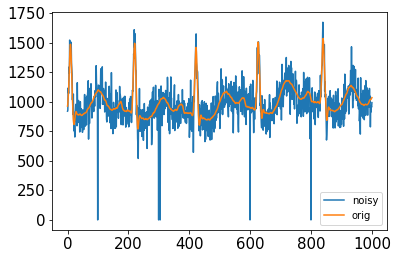

In [83]:
df.plot(fontsize = 15);

In [84]:
df['filtered'] = df['noisy'].copy()

In [85]:
# median filter for small values

thresh = 321

# find subthreshhold-data indices

subthreshidx = np.where(df['filtered']<thresh)[0]

# apply median filter

k = 7

for i in subthreshidx:
  df['filtered'][i] = np.median(df['filtered'][np.max((0,i-k)):np.min((i+k,len(df)))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


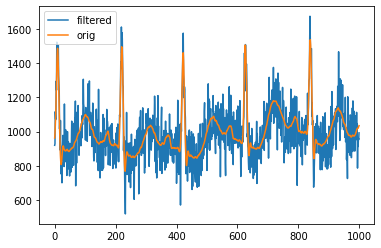

In [86]:
df[['filtered','orig']].plot()

In [87]:
# apply median filter

k = 7

for i in range(len(df)):
  df['filtered'][i] = np.mean(df['filtered'][np.max((0,i-k)):np.min((i+k,len(df)))])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


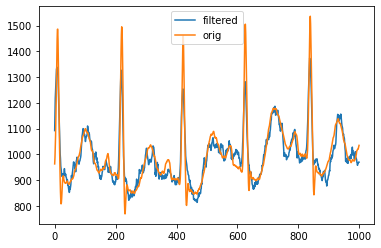

In [88]:
df[['filtered','orig']].plot()

(-5.689437727432111, 72.28749724564085)

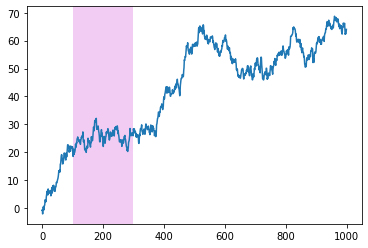

In [90]:
# creating a brownian time series

x = np.cumsum(np.random.randn(1000))

fig,ax = plt.subplots(1)
ax.plot(x)
ylim = ax.get_ylim()
ax.fill_between([100,300],ylim[0],ylim[1],facecolor = 'm',alpha = 0.2)
ax.set_ylim(ylim)



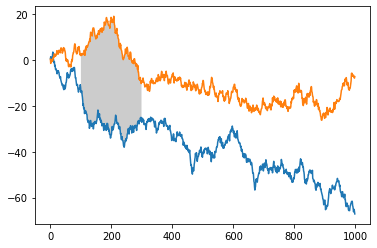

In [94]:
x1 = np.cumsum(np.random.randn(1000))
x2 = np.cumsum(np.random.randn(1000))

fig,ax = plt.subplots(1)
ax.plot(x1)
ax.plot(x2)

xlim = np.arange(100,300)
ax.fill_between(xlim,x1[xlim],x2[xlim],facecolor = 'k',alpha = 0.2)
